# Machine Leanring Project, Task 1: Feature Engineering

In [1]:
# Imports
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Utility Methods

In [2]:
def haversine_distance(origin, destination):
    """
    # Formula to calculate the spherical distance between 2 coordinates, with each specified as a (lat, lng) tuple

    :param origin: (lat, lng)
    :type origin: tuple
    :param destination: (lat, lng)
    :type destination: tuple
    :return: haversine distance
    :rtype: float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(
        math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

## Feature Engineering
> TODO: You need to implement the two functions below to take in raw data, perform data preprocessing and create new features using your knowledge of the problem domain. The main difference between processing test and training data is that **you cannot filter out records from the test set** (i.e., you have to return a prediction even if the input data may be an outlier).

> Feel free to add additional cells to explore the data. You will also find it very helpful to visualize the distribution of the dataset to get a sense of the trends or patterns. **However, you will want to exclude these cells when we export the notebook as an executable.** The submitter will exclude any cells tagged with `excluded_from_script`, so make sure you tag any cells containing exploration code appropriately. You can display the tags for each cell as such: `View > Cell Toolbar > Tags`.

In [12]:
def calculateDistance(raw_df, lat1, lon1, lat2, lon2, new_column_name):
    new_column=[]
    for index,row in raw_df.iterrows():
        origin = (row[lat1],row[lon1])
        dest = (row[lat2],row[lon2])
        value = haversine_distance(origin, dest)
        new_column.append(value)
    raw_df.insert(1,new_column_name,new_column)
    return raw_df
    
def addThreeAirports(df):
    
    df.loc[:,'jfk_latitude'] = 40.6413111
    df.loc[:,'jfk_longtitude'] = -73.7781391
    
    df.loc[:,'lga_latitude'] = 40.7730136
    df.loc[:,'lga_longtitude'] = -73.8702300
    
    df.loc[:,'ewr_latitude'] = 40.7026322
    df.loc[:,'ewr_longtitude'] = -74.1877659
    
    df.loc[:,'nyc_longtitude'] = -73.9776225
    df.loc[:,'nyc_latitude'] = 40.7638356

    df = addDistances(df)
    
    # normalize the lontitude and latitude
    for longtitude in ['pickup_longitude','dropoff_longitude','jfk_longtitude','lga_longtitude',
                      'ewr_longtitude','nyc_longtitude']: 
        df[longtitude] = df[longtitude].map(lambda x: (x+180)/360)
    for latitude in ['pickup_latitude','dropoff_latitude','jfk_latitude','lga_latitude','ewr_latitude',
                     'nyc_latitude']: 
        df[latitude] = df[latitude].map(lambda x: x/180)
    
    return df

def addDistances(df):
    # calculate the trip distance
    calculateDistance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','trip_distance')
    
    # calcualte the distance between pick up geo point and airports
    for end in ['pickup','dropoff']:
        for airport in ['jfk','lga','ewr','nyc']: 
                calculateDistance(df, end + '_latitude',end + '_longitude',
                                  airport + '_latitude',airport + '_longtitude',
                                  end + '_to_' + airport)
    return df

def dealWithOutliers(train_data):
    lat_upper = 41.0
    lat_lower = 40.0
    long_upper = -73.5 
    long_lower = -74.5
    
    train_data['outlier'] = 1
    train_data.loc[train_data.isnull().any(axis=1), 'outlier'] = 0
    for longtitude in ['pickup_longitude','dropoff_longitude']:
        train_data.loc[train_data[longtitude] > long_upper,'outlier'] = 0
        train_data.loc[train_data[longtitude] < long_lower,'outlier'] = 0
        train_data.loc[train_data[longtitude] == 0.0,'outlier'] = 0
    for latitude in ['pickup_latitude','dropoff_latitude']:
        train_data.loc[train_data[latitude] > lat_upper,'outlier'] = 0
        train_data.loc[train_data[latitude] < lat_lower,'outlier'] = 0
        train_data.loc[train_data[longtitude] == 0.0,'outlier'] = 0
    return train_data

def qcutNumerical(df):
    return pd.get_dummies(df,prefix = ['outlier'], columns= ['outlier']) 
 
def parseDatetime(raw_df):
    raw_df['year'] = raw_df.pickup_datetime.apply(lambda t: t.year)
    raw_df['month'] = raw_df.pickup_datetime.apply(lambda t: t.month) 
    raw_df['weekday'] = raw_df.pickup_datetime.apply(lambda t: t.weekday())
    raw_df['hour'] = raw_df.pickup_datetime.apply(lambda t: t.hour)
    
#     # one hot encoding
#     categorical_cols = ['year','month','weekday','hour']
    
#     for categorical_col in categorical_cols:
#         raw_df[categorical_col] = raw_df[categorical_col].astype('category')
        
#     raw_df = pd.get_dummies(raw_df,prefix=categorical_cols,columns=categorical_cols)
    
    return raw_df

def addMissingDummy(df):
    predefined_cols = [
        'dropoff_to_nyc',
        'dropoff_to_ewr',
        'dropoff_to_lga',
        'dropoff_to_jfk',
        'pickup_to_nyc',
        'pickup_to_ewr',
        'pickup_to_lga',
        'pickup_to_jfk',
        'trip_distance',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'passenger_count',
        'jfk_latitude',
        'jfk_longtitude',
        'lga_latitude',
        'lga_longtitude',
        'ewr_latitude',
        'ewr_longtitude',
        'nyc_longtitude',
        'nyc_latitude',
        'year_2009',
        'year_2010',
        'year_2011',
        'year_2012',
        'year_2013',
        'year_2014',
        'year_2015',
        'month_1',
        'month_2',
        'month_3',
        'month_4',
        'month_5',
        'month_6',
        'month_7',
        'month_8',
        'month_9',
        'month_10',
        'month_11',
        'month_12',
        'weekday_0',
        'weekday_1',
        'weekday_2',
        'weekday_3',
        'weekday_4',
        'weekday_5',
        'weekday_6',
        'hour_0',
        'hour_1',
        'hour_2',
        'hour_3',
        'hour_4',
        'hour_5',
        'hour_6',
        'hour_7',
        'hour_8',
        'hour_9',
        'hour_10',
        'hour_11',
        'hour_12',
        'hour_13',
        'hour_14',
        'hour_15',
        'hour_16',
        'hour_17',
        'hour_18',
        'hour_19',
        'hour_20',
        'hour_21',
        'hour_22',
        'hour_23',
        'outlier_0',
        'outlier_1',
        ]
    missing_cols = set(predefined_cols) - set(df.columns)
    for col in missing_cols:
        df.loc[:, col] = 0
    return df

In [4]:
def process_train_data(raw_df):
    # delete some abnormal rows
    raw_df = raw_df[(raw_df['fare_amount'] > 0) & (raw_df['fare_amount'] < 100)] # cannot delete man...
    
    # frist step to deal with abnormal data point
    cleaned_raw_data = dealWithOutliers(raw_df)
    
    # add airports and convert coodinates to distances
    cleaned_data_with_distances = addThreeAirports(cleaned_raw_data)
    
    # date time one-hot encoding
    cleaned_data_with_distance_and_time = parseDatetime(cleaned_data_with_distances)
    
#     # qcut the numerical variables
#     cleaned_data_with_distance_and_time_qcut = qcutNumerical(cleaned_data_with_distance_and_time)
    
    # delete the pickup_datetime
    candidate = cleaned_data_with_distance_and_time
    
#     # add the missing dummy cols
#     final = addMissingDummy(candidate)
    
    return candidate


def process_test_data(raw_df):
    # frist step to deal with abnormal data point
    cleaned_raw_data = dealWithOutliers(raw_df)
    
    # add airports and convert coodinates to distances
    cleaned_data_with_distances = addThreeAirports(cleaned_raw_data)
    
    # parse datatime this can be ver different
    cleaned_data_with_distance_and_time = parseDatetime(cleaned_data_with_distances)
    
#     # do the qcut for the numerical variables
#     cleaned_data_with_distance_and_time_qcut = qcutNumerical(cleaned_data_with_distance_and_time)

    # return the result
    return cleaned_data_with_distance_and_time

## Model Checking with XGBoost and k-fold Cross Validation
> As you iterate on your features, you want to quickly validate the model and evaluate if these new features help to improve your model's predictions. This process is known as model checking. You will use XGBoost to train the model, and use Root Mean Squared Error (RMSE) to quantify the performance. Cross validation is used to evaluate how the performance of the model will generalize to an unseen dataset.

In [5]:
# Load data
raw_train = pd.read_csv('data/cc_nyc_fare_train_small.csv', parse_dates=['pickup_datetime'])
print('Shape of the raw data: {}'.format(raw_train.shape))

Shape of the raw data: (110222, 8)


In [13]:
list(parseDatetime(raw_train).columns)

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'year_2009',
 'year_2010',
 'year_2011',
 'year_2012',
 'year_2013',
 'year_2014',
 'year_2015',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23']

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

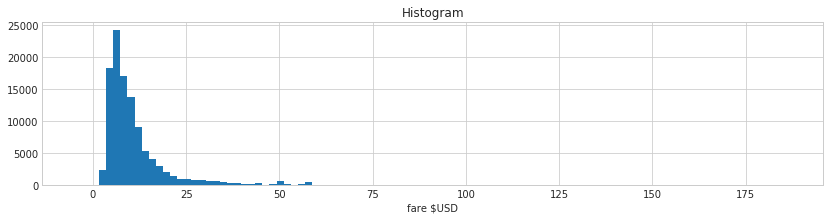

In [8]:
# plot histogram of fare
raw_train[raw_train.fare_amount < 200].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

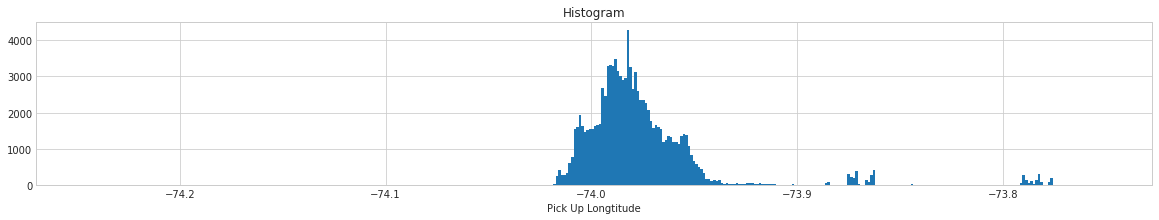

In [9]:
# plot histogram of pickup_longitude
raw_train[(raw_train.pickup_longitude > -74.25) & (raw_train.pickup_longitude < -73.75)].pickup_longitude.hist(bins = 400,figsize=(20,3)) 
plt.xlabel('Pick Up Longtitude')
plt.title('Histogram');

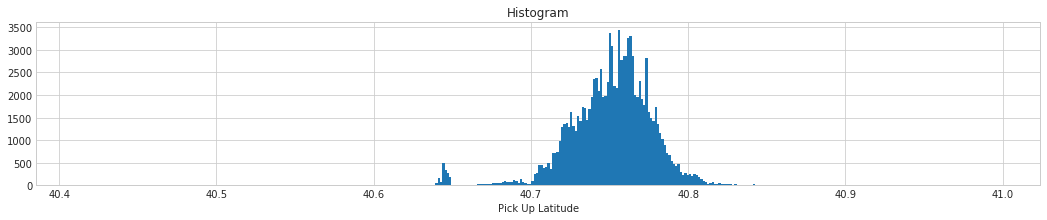

In [10]:
# plot histogram of pickup_longitude
raw_train[(raw_train.pickup_latitude < 41) & (raw_train.pickup_latitude > 40.4)].pickup_latitude.hist(bins = 400,figsize=(18,3)) 
plt.xlabel('Pick Up Latitude')
plt.title('Histogram');

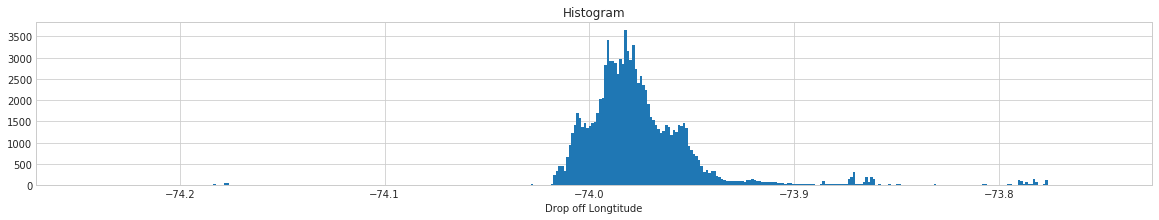

In [11]:
# plot histogram of pickup_longitude
raw_train[(raw_train.dropoff_longitude < -73.75) & (raw_train.dropoff_longitude > -74.25)].dropoff_longitude.hist(bins = 400,figsize=(20,3)) 
plt.xlabel('Drop off Longtitude')
plt.title('Histogram');

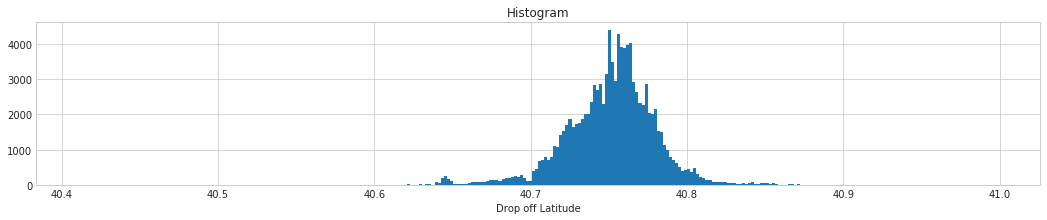

In [12]:
# plot histogram of pickup_longitude
raw_train[(raw_train.dropoff_latitude < 41) & (raw_train.dropoff_latitude > 40.4)].dropoff_latitude.hist(bins = 300,figsize=(18,3)) 
plt.xlabel('Drop off Latitude')
plt.title('Histogram');

In [16]:
# read data in pandas dataframe
df_test =  pd.read_csv('data/cc_nyc_fare_test.csv',parse_dates=["pickup_datetime"])
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-05-21 06:28:12.0000002,2010-05-21 06:28:12,-73.948402,40.776676,-73.981739,40.759825,1
1,2012-02-07 22:39:00.000000107,2012-02-07 22:39:00,-74.012947,40.717042,-73.989977,40.757097,1
2,2012-12-04 22:22:12.0000002,2012-12-04 22:22:12,-73.977211,40.745275,-73.977211,40.745275,1
3,2011-05-08 13:15:18.0000002,2011-05-08 13:15:18,-73.947803,40.770538,-73.790332,40.643815,1
4,2015-05-20 01:40:28.0000001,2015-05-20 01:40:28,-73.971413,40.760414,-73.962608,40.762306,2


In [17]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-74.057711,40.847857,-74.059165,40.836837,1.696000
std,16.091322,16.832402,12.495058,15.634208,1.319984
min,-1656.640193,-74.003617,-1183.275658,-74.000940,1.000000
25%,-73.992352,40.736396,-73.991855,40.735574,1.000000
50%,-73.982182,40.753447,-73.980755,40.753511,1.000000
75%,-73.968666,40.767488,-73.965924,40.768363,2.000000
max,40.788082,1700.303268,40.784985,1578.631433,6.000000


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

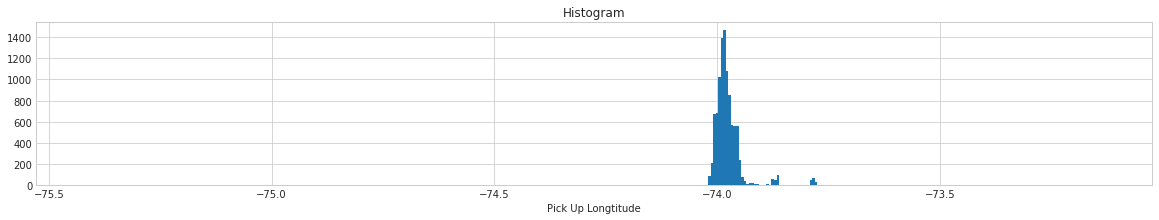

In [21]:
df_test[(df_test.pickup_longitude < -70.00) & (df_test.pickup_longitude > -80.00)].pickup_longitude.hist(bins = 400,figsize=(20,3)) 
plt.xlabel('Pick Up Longtitude')
plt.title('Histogram');

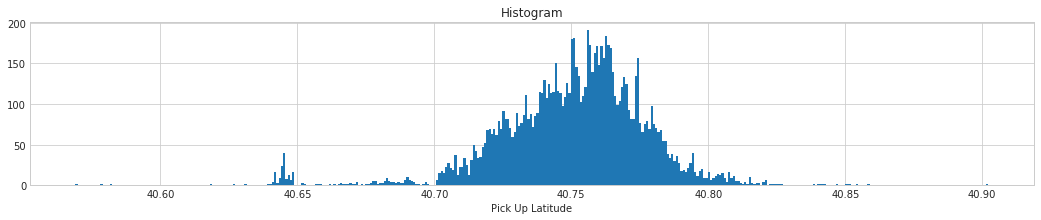

In [33]:
# plot histogram of pickup_longitude
df_test[(df_test.pickup_latitude < 41) & (df_test.pickup_latitude > 40.5)].pickup_latitude.hist(bins = 400,figsize=(18,3)) 
plt.xlabel('Pick Up Latitude')
plt.title('Histogram');

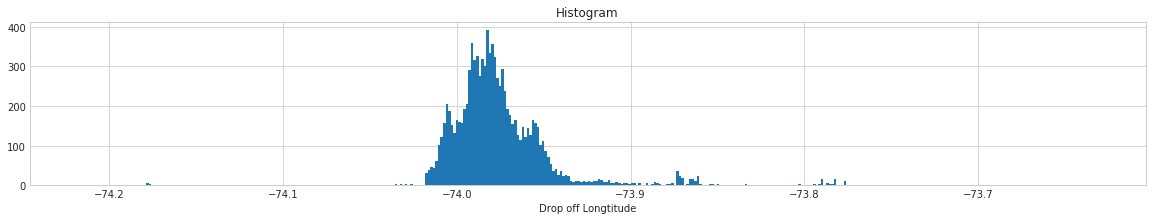

In [27]:
# plot histogram of pickup_longitude
df_test[(df_test.dropoff_longitude < -73.5) & (df_test.dropoff_longitude > -74.5)].dropoff_longitude.hist(bins = 400,figsize=(20,3)) 
plt.xlabel('Drop off Longtitude')
plt.title('Histogram');

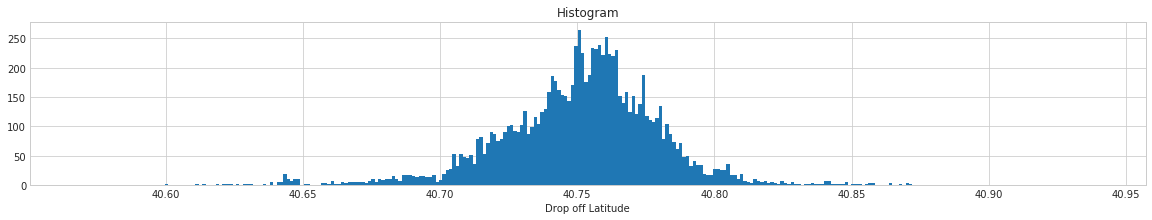

In [32]:
# plot histogram of pickup_longitude
df_test[(df_test.dropoff_latitude < 41) & (df_test.dropoff_latitude > 40.5)].dropoff_latitude.hist(bins = 300,figsize=(20,3)) 
plt.xlabel('Drop off Latitude')
plt.title('Histogram');

In [26]:
print(raw_train.shape)
df_train = raw_train[(raw_train['fare_amount'] >= 0) & (raw_train['fare_amount'] <= 100)]
print(df_train.shape)
print("{} rows has been deleted.".format(raw_train.shape[0] - df_train.shape[0]))

(110222, 38)
(110177, 38)
45 rows has been deleted.


In [ ]:
print(df_train.shape)
# frist step to deal with abnormal data point
cleaned_df_train = dealWithOutliers(df_train)
print(cleaned_df_train.shape)
print("{} rows has been deleted.".format(df_train.shape[0] - cleaned_df_train.shape[0]))

In [ ]:
print(cleaned_df_train.shape)
# add airports and convert coodinates to distances
cleaned_df_train_with_distance = addThreeAirports(cleaned_df_train)
print(cleaned_df_train_with_distance.shape)

In [ ]:
list(cleaned_df_train.columns)

In [ ]:
list(cleaned_df_train_with_distance.columns)

In [ ]:
# date time one-hot encoding
cleaned_df_train_with_distance_and_time = parseDatetime(cleaned_df_train_with_distance)

In [ ]:
list(cleaned_df_train_with_distance_and_time.columns)

In [ ]:
# qcut the numerical variables
cleaned_df_train_with_distance_and_time_qcut = qcutNumerical(cleaned_df_train_with_distance_and_time)

In [ ]:
list(cleaned_df_train_with_distance_and_time_qcut.columns)

In [ ]:
# correct the columns
cleaned_data_with_distance_and_time_qcut_correct = correctColumns(cleaned_df_train_with_distance_and_time_qcut)

In [ ]:
list(cleaned_data_with_distance_and_time_qcut_correct.columns)

In [ ]:
cleaned_data_with_distance_and_time_qcut_correct.shape

In [ ]:
X = cleaned_data_with_distance_and_time_qcut_correct.drop(['key', 'fare_amount', 'pickup_datetime'], axis=1)
Y = cleaned_data_with_distance_and_time_qcut_correct['fare_amount']

In [14]:
# Transform features using the function you have defined
df_train = process_train_data(raw_train)

# Remove fields that we do not want to train with
X = df_train.drop(['key', 'fare_amount', 'pickup_datetime'], axis=1)

# Extract the value you want to predict
Y = df_train['fare_amount']
print('Shape of the feature matrix: {}'.format(X.shape))

Shape of the feature matrix: (110170, 74)


In [16]:
len(X.columns)

74

In [8]:
# Evaluate features with K-fold cross validation
# The higher K is, the longer it takes to run, and the higher your confidence in the score
K = 5
model = XGBRegressor()
scores = cross_val_score(model, X, Y, cv=K, scoring='neg_mean_squared_error', verbose=False)
avg_rmse = math.sqrt(abs(np.mean(scores)))

print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))

Average RMSE with 5-fold Cross Validation: 226.325


## Evaluating Feature Importance
> After you train the model, XGBoost has a handy utility that allows you to compare the relative importance of each feature. You should use this to assess which features you created are meaningful. 

In [ ]:
# Train the model again with the entire training set
model = XGBRegressor()
model.fit(X, Y)
xgb.plot_importance(model, height=0.8)

## Evaluating against Hidden Test Set
> Once you are satisfied with the performance of the features you have selected, you can use the trained model to make predictions on the hidden test set. **Do not change the default configuration of the model.** In task 1, you want to focus on feature selection, without worrying about tuning the model.

In [ ]:
raw_test = pd.read_csv('data/cc_nyc_fare_test.csv', parse_dates=['pickup_datetime'])
# df_test = process_test_data(raw_test)

In [ ]:
# frist step to deal with abnormal data point
clean_test_set = dealWithOutliers(raw_test)

In [ ]:
clean_test_set.head()

In [ ]:
# add airports and convert coodinates to distances
clean_test_set_with_distance = addThreeAirports(clean_test_set)

In [ ]:
clean_test_set_with_distance.head()

In [ ]:
clean_test_set_with_distance.shape

In [ ]:
# parse datatime this can be ver different
clean_test_set_with_distance_and_time = parseDatetime(clean_test_set_with_distance)

In [ ]:
clean_test_set_with_distance_and_time.shape

In [ ]:
# do the qcut for the numerical variables
clean_test_set_with_distance_and_time_qcut = qcutNumericalForTestingSet(clean_test_set_with_distance_and_time)

In [ ]:
clean_test_set_with_distance_and_time_qcut.shape

In [ ]:
clean_test_set_with_distance_and_time_qcut.head()

In [ ]:
# correct the columns
clean_test_set_with_distance_and_time_qcut_correct = correctColumns(clean_test_set_with_distance_and_time_qcut)

In [ ]:
list(clean_test_set_with_distance_and_time_qcut_correct.columns)

In [ ]:
clean_test_set_with_distance_and_time_qcut_correct.shape

In [ ]:
test_list = set(clean_test_set_with_distance_and_time_qcut_correct.columns)

In [ ]:
train_list = set(cleaned_data_with_distance_and_time_qcut_correct)

In [ ]:
diff = train_list - test_list

In [ ]:
diff

In [ ]:
final_model = XGBRegressor()
final_model.fit(X, Y)
X_test = clean_test_set_with_distance_and_time_qcut_correct.drop(['key', 'pickup_datetime'], axis=1)
df_test['predicted_fare_amount'] = final_model.predict(X_test)
df_test[['key', 'predicted_fare_amount']].to_csv('predictions.csv', index=False)

In [ ]:
# Build final model with the entire training set
final_model = XGBRegressor()
final_model.fit(X, Y)

# Read and transform test set
raw_test = pd.read_csv('data/cc_nyc_fare_test.csv', parse_dates=['pickup_datetime'])
df_test = process_test_data(raw_test)
X_test = df_test.drop(['key', 'pickup_datetime'], axis=1)

# Make predictions for test set and output a csv file
# DO NOT change the column names
df_test['predicted_fare_amount'] = final_model.predict(X_test)
df_test[['key', 'predicted_fare_amount']].to_csv('predictions.csv', index=False)